# Imports and utility functions

In [59]:
import numpy as np
import time, glob, gc, os, sys, re
import pandas as pd
import seaborn as sns
import tifffile
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import xarray as xr
import tpae.data.ingest as ti

data_dir = '../uc-data'
raw_dir = f'{data_dir}/raw'
out_dir = f'{data_dir}/10u'
metadata = pd.read_csv(f'{data_dir}/UC_Project_Metadata_Truncated.csv')
os.makedirs(f'{raw_dir}', exist_ok=True)
os.makedirs(f'{out_dir}', exist_ok=True)

pixelsize = 0.75488 # in microns
downsample_factor = int(10//pixelsize)

k = 10
repname = f'pca_k={k}_harmony'

# read in channel names and files 
channel_names_filepath = f'{data_dir}/channelNames.txt'
with open(channel_names_filepath, 'r') as file: 
    markers = file.read().splitlines()

files = glob.glob(f"{data_dir}/raw/run[1-36-8]/*.tif")

# Read raw data and downsample

In [8]:
# convert all files to xarray

for file in files:     
    da = tifffile.TiffFile(file)
    da = da.asarray().astype('uint16')
    da = np.reshape(da, newshape = (-1, da.shape[2], da.shape[3])).transpose(1, 2, 0)
    da = ti.downsample(da, factor = downsample_factor)
    
    run = os.path.basename(os.path.dirname(file))
    file = os.path.basename(re.sub("00", "", file.split("_")[0]))
    file = f"{run}{file}"
    sample_id = metadata.loc[metadata['Run Info'] == file, :] #*** metadata[metadata['Run Info'] == 'run1reg1'].iloc[0], call it sampleinfo
    
    if sample_id.shape[0] == 1: 
        sid = sample_id['Patient ID# for manuscript'].values[0]  #*** sampleinfo['Patient ID# for manuscript']
        donor_id = sample_id['Patient.ID'].values[0] #*** sampleinfo['...']
        da = xr.DataArray(da, 
                          dims = ("y", "x", "marker"), 
                          coords = {"y": np.arange(da.shape[0], dtype = np.float32),
                                    "x": np.arange(da.shape[1], dtype = np.float32),
                                    'marker': markers}, 
                          attrs = {"name": sid, #*** name -> sid
                                   "donor": donor_id}, 
                          name = sid) 
        da.to_netcdf(f"{out_dir}/{sid}.nc", 
                                  format = "NETCDF4", 
                                  encoding = {da.name: {'zlib': True, 'complevel': 2}}) #use ti.compression
        print(f"{sid} done")

UC29 done
UC28 done
UC11 done
UC3 done
UC8 done
UC1 done
UC2a done
UC2b done
UC15 done
UC26 done
UC9 done
UC10 done
UC21 done
UC4a done
UC4b done
UC4c done
UC7 done
UC14a done
UC14b done
UC17 done
UC25 done
HC2b done
HC2a done
HC1 done
HC5 done
HC4 done
HC3 done
UC13b done
UC5 done
UC6 done
UC27 done
UC16a done
UC16b done
UC13a done
UC19 done
UC12 done
UC23b done
UC23a done
UC20 done
UC24 done
UC22 done


**note:** 349 x 362 is smaller than other datasets we've looked at, just fyi. No action item

# Visual sanity checks

In [71]:
# read in data
samples = [
    xr.open_dataarray(f, engine='netcdf4')
    for f in glob.glob(f"{out_dir}/*.nc")
]

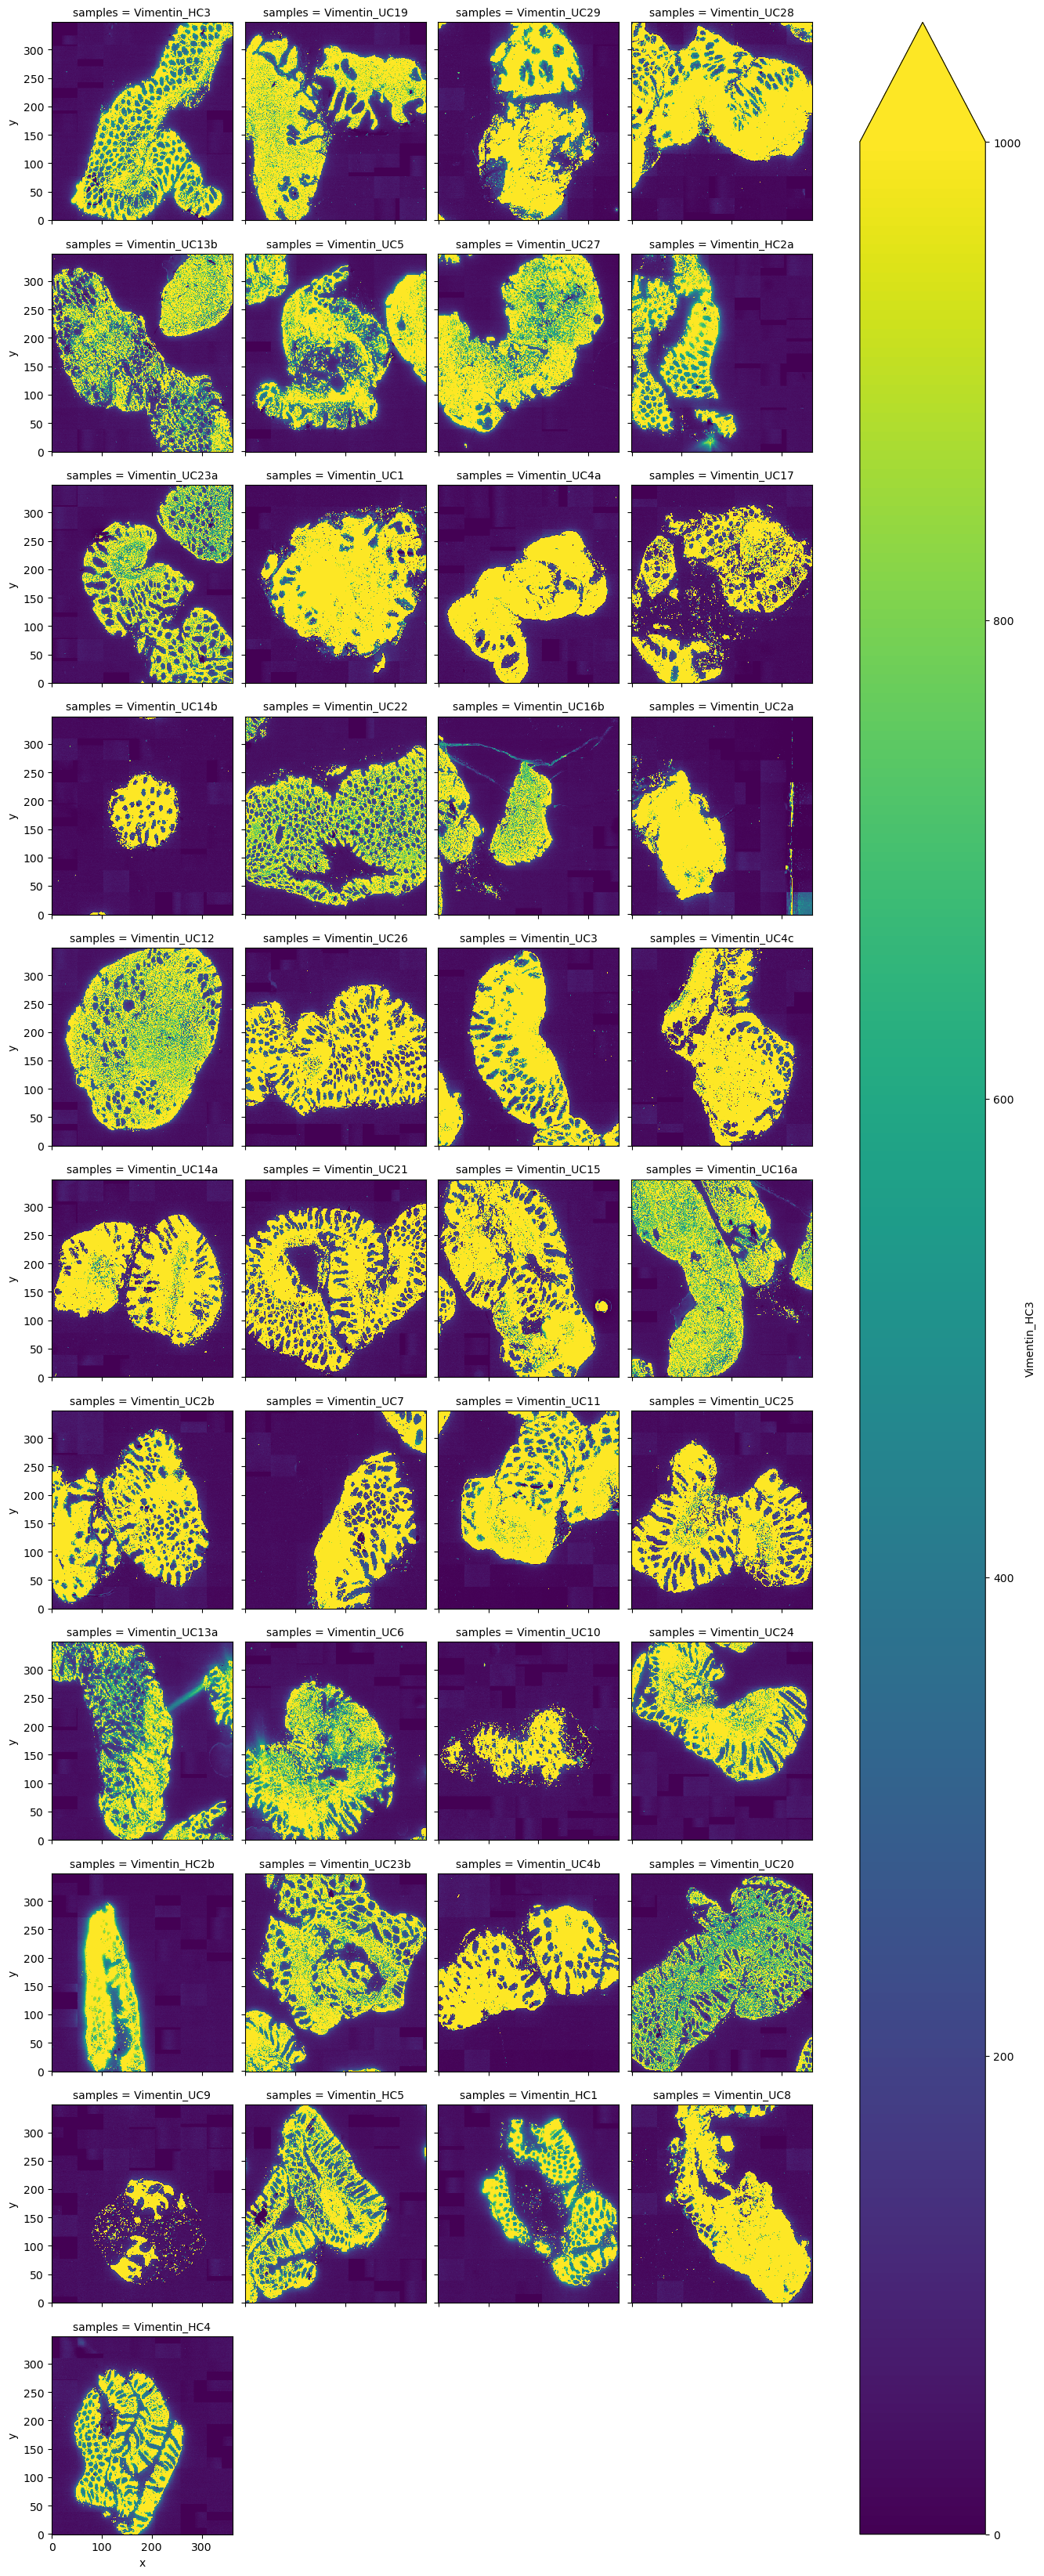

In [105]:
def extract_marker(s, stain): 
    res = s.sel(marker=stain).rename(f"{stain}_{s.name}")
    res = res.rename({"marker": "samples"}).assign_coords({"samples": f"{stain}_{s.name}"})
    return(res)

vimentin = xr.concat([
    extract_marker(s, "Vimentin") for s in samples
], dim = 'samples') # nice

vimentin.plot(col='samples', col_wrap = 4, vmax = 1000)

# Identify foreground

In [73]:
# read in data
samples = [
    xr.open_dataarray(f, engine='netcdf4')
    for f in glob.glob(f"{out_dir}/*.nc")
]

In [111]:
all_markers = [marker for marker in markers if "blank" not in marker]
neg_ctrls = [marker for marker in all_markers if "empty" in marker]
real_markers = [marker for marker in all_markers if "empty" not in marker and 'HOECHST' not in marker]
blur_width = 5

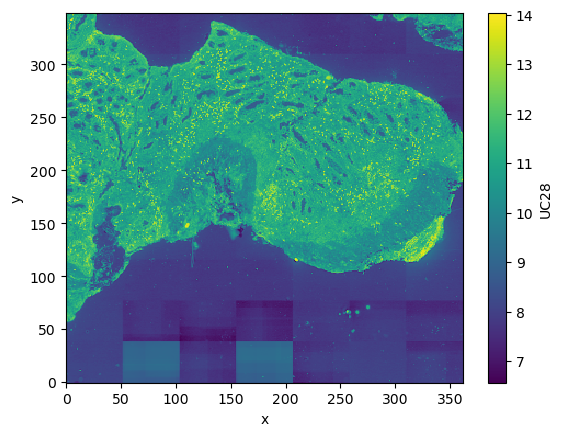

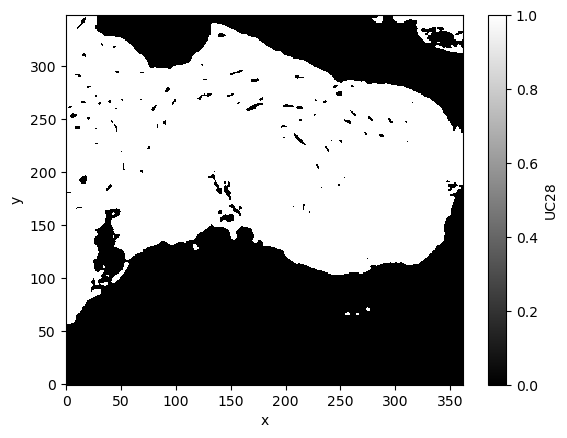

In [141]:
s = samples[3]
# mask = foreground_mask_codex(s, real_markers, neg_ctrls)
np.log1p(s.sel(marker=real_markers).sum(dim='marker')).plot()
plt.show()
mask.plot(cmap='gray')
plt.show()

In [137]:
import cv2 as cv2
def foreground_mask_codex(s, real_markers, neg_ctrls, blur_width=5):
    # compute totals
    totals = s.sel(marker=real_markers).sum(dim='marker')
    totals = np.log1p(totals)
    totals -= totals.min()
    totals /= (totals.max()/255)
    totals = totals.astype('uint16')

    # determine foreground vs background
    blurred = cv2.GaussianBlur(totals.data,(blur_width, blur_width),0)
    _, mask = cv2.threshold(blurred,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    return xr.DataArray(mask.astype('bool'),
                coords={'x': totals.x, 'y': totals.y},
                dims=['y','x'], name=s.name)

In [ ]:
from importlib import reload; reload(ti)

sids=[os.path.basename(s).split(".nc")[0] for s in glob.glob(f"{out_dir}/*.nc")]
masksdir='../uc-data/masks'
get_foreground = lambda s: ti.foreground_mask_ihc(s, real_markers, neg_ctrls, blur_width=blur_width)
ti.write_masks(out_dir, masksdir, get_foreground, sids)
os.system('say done')

# to-do

For prior code:
- [ ] address outstanding comments
- [ ] modify downsampling code to add 'sid' and 'donor' to s.attrs as well sid to s.name, and saves to f'{data_dir}/10u/counts' (with compression={'zlib': True, 'complevel': 2} and filename of {sid}.nc)
- [ ] use new foreground_codex function to generate masks for all samples, and examine the diagnostic plots that are created to make sure they look reasonable
- [ ] if happy, push new foreground_codex function to ti

For future:
- [ ] 

# Normalize

In [ ]:
from importlib import reload; reload(ti)
def transform(X):
    return (1+X[:,:-1]) / (1+X[:,-1])[:,None] #adjust to use the empty dyes rather than the last channel

def get_sumstats(pixels):
    pixels = transform(pixels)
    ntranscripts = pixels.sum(axis=1, dtype=np.float64)
    med_ntranscripts = np.median(ntranscripts)
    pixels = np.log1p(med_ntranscripts * pixels / ntranscripts[:,None])
    means = pixels.mean(axis=0, dtype=np.float64)
    stds = pixels.std(axis=0, dtype=np.float64)
    return {'means':means, 'stds':stds, 'med_ntranscripts':med_ntranscripts}

def normalize_bham(mask, s, med_ntranscripts=None, means=None, stds=None):
    s = s.where(mask, other=0)
    pl = ti.xr_to_pixellist(s, mask)
    pl = transform(pl)
    pl = np.log1p(med_ntranscripts * pl / pl.sum(axis=1)[:,None])
    pl -= means
    pl /= stds
    s = s.sel(marker=markers[:-1]) # adjust to use empty dyes rather than AF
    ti.set_pixels(s, mask, pl)
    s.attrs['med_ntranscripts'] = med_ntranscripts
    s.attrs['means'] = means
    s.attrs['stds'] = stds
    return s

ti.normalize_allsamples(downsampledpixelsdir, masksdir, normedpixelsdir, sids,
                               get_sumstats=get_sumstats_bham,
                               normalize=normalize_bham)

# scratch

In [132]:
# Testing background subtraction via simple linear regression 

from sklearn.linear_model import LinearRegression



In [61]:
pred_background = foreground_mask_ihc(samples[0], real_markers, neg_ctrls, blur_width=5)

In [63]:
np.unique(pred_background)

array([0.])

In [42]:
totals = foreground_mask_ihc(samples[0]['UC29'], real_markers, neg_ctrls, blur_width=5)

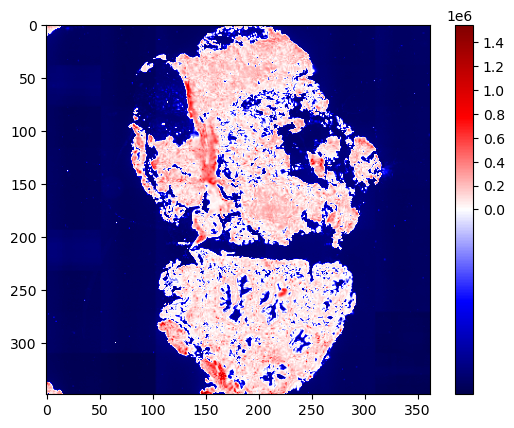

In [47]:
fig, ax = plt.subplots()
divnorm=mcolors.TwoSlopeNorm(vmin=totals.min(), vcenter=0., vmax=totals.max())
im = ax.imshow(totals, cmap = 'seismic', norm = divnorm) 
fig.colorbar(im, ax = ax)

In [44]:
totals

array([[ 24404.9772086 , 382535.33815534, 281874.23756363, ...,
        -59489.69143046, -59540.9636198 , -59582.84527661],
       [ 44677.33223818, 115402.22572931, 287721.79969381, ...,
        -59125.69734761, -59095.73285057, -58963.25947779],
       [100435.39732694, 194591.52750446, 280622.05413168, ...,
        -58937.80385649, -58885.76243637, -58929.75060205],
       ...,
       [ 38578.61034469, 250244.75827369, 363358.52750446, ...,
        -62427.11746596, -62401.38965531, -62546.92219969],
       [  6375.90028552, 134579.14880623,  75014.84703108, ...,
        -62575.69143046, -62544.76835353, -62558.70326477],
       [150287.56892457, 186564.01862872, -43757.36598667, ...,
        -62636.41332395, -62587.49024702, -62521.52574998]])